# Dog Breed Classification with Transfer Learning on AWS SageMaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.

This notebook demonstrates the complete machine learning workflow on **AWS SageMaker**. We will be using **transfer learning** with a pre-trained PyTorch model to classify dog breeds from images.

The primary steps covered are:
1.  **Data Preparation and Upload** to S3.
2.  **Hyperparameter Optimization (HPO)** using SageMaker's built-in tuning capabilities to find the best learning rate and batch size.
3.  **Model Training, Profiling, and Debugging** using the best parameters, leveraging **SMDebug** for monitoring training issues like overfitting and poor initialization.
4.  **Model Deployment** to a real-time HTTPS endpoint for prediction.

In [20]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp312-cp312-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.28.3
    Uninstalling protobuf-5.28.3:
      Successfully uninstalled protobuf-5.28.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [smdebug]m3/4 [smdebug]]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-studio 1.1.1 requires pydynamodb>=0.7.4, which is not installed.
databricks-sdk 0.73.0 requires protobuf!=5.26.*,!=5.27

In [22]:
!pip install protobuf==3.20.3

In [1]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
import os
import math
import numpy as np
import pandas as pd
from sagemaker.pytorch import PyTorch

In [8]:
sess = sagemaker.Session()

bucket= sess.default_bucket() ## TODO: fill in
print("Default Bucket: {}".format(bucket))

region = sess.boto_region_name## TODO: fill in
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()## TODO: fill in
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-625312441903
AWS Region: us-east-1
RoleArn: arn:aws:iam::625312441903:role/service-role/AmazonSageMaker-ExecutionRole-20251217T201820


In [5]:
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

## Dataset

We are using the **Dog Breed Identification dataset**, which contains images of 133 different dog breeds.

* **Total Classes:** 133 unique dog breeds.
* **Data Split:** The dataset is organized into three folders: `train`, `valid` (validation), and `test`.
* **Challenge:** The number of images per class can be relatively small, making this a good candidate for **transfer learning** where a model pre-trained on a massive dataset (like ImageNet) is fine-tuned on this specific task.
* **Goal:** The model's objective is to correctly predict the breed of the dog in an image.

In [6]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2025-12-17 15:13:46--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.194.136, 52.219.113.24, 16.15.0.137, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.194.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  14.2MB/s    in 44s     

2025-12-17 15:14:31 (24.7 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  

In [7]:
data_path = 'dogImages'
s3_prefix = 'dogImages'

# Upload the data to S3
input_data = sess.upload_data(path=data_path, bucket=bucket, key_prefix=s3_prefix)
print(f"Input data uploaded to: {input_data}")

Input data uploaded to: s3://sagemaker-us-east-1-625312441903/dogImages


In [6]:
import sagemaker

# 1. Re-initialize the session and get the default bucket
sess = sagemaker.Session()
bucket = sess.default_bucket()

# 2. Define the prefix you used previously
s3_prefix = 'dogImages'

# 3. Construct the S3 path manually instead of uploading
input_data = "s3://{}/{}".format(bucket, s3_prefix)

print(f"Input data path: {input_data}")

Input data path: s3://sagemaker-us-east-1-625312441903/dogImages


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

We perform Hyperparameter Optimization (HPO) using SageMaker's **HyperparameterTuner** to find the optimal configuration for our PyTorch model. We are tuning the following hyperparameters:

| Hyperparameter | Type | Range | Rationale |
| :--- | :--- | :--- | :--- |
| **Learning Rate (`lr`)** | Continuous | [0.001, 0.1] | The learning rate is critical for controlling the step size during optimization. Too large, and the model diverges; too small, and training is slow. We use a logarithmic range to explore various scales. |
| **Batch Size (`batch-size`)** | Integer | [32, 128] | The batch size affects both training stability and GPU memory usage. Larger batches can converge faster but might generalize poorly. We test common sizes for image classification. |

The objective is to **Minimize** the `average test loss` (which is the loss calculated on the validation set during training).

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
#TODO: Declare your HP ranges, metrics etc.

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": IntegerParameter(32, 128), 
    'epochs': IntegerParameter(2, 6)
}

# Define the objective metric to optimize
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


In [7]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",  # or ml.m5.large / ml.p3.2xlarge depending on quota
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [8]:
# TODO: Fit your HP Tuner
# We pass the S3 path of our data to the fit method
tuner.fit({"training": input_data})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.....................................................................................................................................................................................................................................................................................................................................................................................................................!


In [9]:
# TODO: Get the best estimators and the best HPs

# Get the best training job name
best_training_job = tuner.best_training_job()

# Create an estimator from the best training job
best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2025-12-17 17:51:36 Starting - Found matching resource for reuse
2025-12-17 17:51:36 Downloading - Downloading the training image
2025-12-17 17:51:36 Training - Training image download completed. Training in progress.
2025-12-17 17:51:36 Uploading - Uploading generated training model
2025-12-17 17:51:36 Completed - Resource reused by training job: pytorch-training-251217-1722-004-5b9ba817


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '100',
 'epochs': '5',
 'lr': '0.0023832264170425455',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2025-12-17-17-22-28-202"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-625312441903/pytorch-training-2025-12-17-17-22-28-202/source/sourcedir.tar.gz"'}

In [10]:
tuner.analytics().dataframe()

,batch-size,epochs,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,78.0,3.0,0.003123,pytorch-training-251217-1722-004-5b9ba817,Completed,0.0096,2025-12-17 17:51:38+00:00,2025-12-17 17:56:53+00:00,315.0
1,100.0,5.0,0.002383,pytorch-training-251217-1722-003-5ff03eb8,Completed,0.0062,2025-12-17 17:43:08+00:00,2025-12-17 17:51:09+00:00,481.0
2,62.0,4.0,0.061824,pytorch-training-251217-1722-002-7f8e3b55,Completed,0.0817,2025-12-17 17:35:24+00:00,2025-12-17 17:42:24+00:00,420.0
3,104.0,4.0,0.010501,pytorch-training-251217-1722-001-de568cef,Completed,0.0202,2025-12-17 17:23:50+00:00,2025-12-17 17:34:37+00:00,647.0


In [27]:
# Best hyperparameters found:
best_estimator_hyperparameters=best_estimator.hyperparameters()

allhyperparameters = {"batch_size": int(best_estimator_hyperparameters['batch-size']),
                   "lr": best_estimator_hyperparameters['lr'],
                   "epochs":best_estimator_hyperparameters['epochs']
                  }
allhyperparameters

{'batch_size': 100, 'lr': '0.0023832264170425455', 'epochs': '5'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

Using the best hyperparameters found from the HPO job, we will train the final model. This time, we incorporate **SageMaker Debugger (SMDebug)** to monitor the training job for potential issues and profile resource utilization.

We have configured the following Debugger **Rules**:
1.  **Vanishing Gradient:** Checks if the average gradient norm is too low, indicating training has stalled.
2.  **Overfitting/Overtraining:** Monitors the difference between training loss and validation loss to catch when the model starts performing significantly worse on unseen data.
3.  **ProfilerReport:** Generates a comprehensive report on resource utilization (CPU, GPU, I/O) and framework operation (data loading, forward pass, backward pass) to identify bottlenecks.
   
**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [17]:
# TODO: Set up debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [18]:
hyperparameters = {'_tuning_objective_metric': '"average test loss"',
 'batch-size': '100',
 'epochs': '5',
 'lr': '0.0023832264170425455',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2025-12-17-17-22-28-202"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-625312441903/pytorch-training-2025-12-17-17-22-28-202/source/sourcedir.tar.gz"'}

In [19]:
type(hyperparameters)

dict

In [20]:
# TODO: Create and fit an estimator

# Retrieve best hyperparameters
#hyperparameters = best_estimator.hyperparameters()

# Create the new estimator with debug hooks
estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py36',
    framework_version="1.8",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

estimator.fit({"training": input_data})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2025-12-17-19-14-57-902


2025-12-17 19:14:59 Starting - Starting the training job
2025-12-17 19:14:59 Pending - Training job waiting for capacity...
2025-12-17 19:15:27 Pending - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2025-12-17 19:16:01 Downloading - Downloading input data......
2025-12-17 19:17:01 Downloading - Downloading the training image........................
2025-12-17 19:21:03 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-12-17 19:20:55,318 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-12-17 19:20:55,346 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-12-17 19:20:55,350 sagemaker_pytorch_container.training INFO     Invoking user trai

In [21]:
# Print training job information:
print("job name : {}\n".format(estimator.latest_training_job.job_name))
print("latest_job_debugger_artifacts_path : {}\n".format(estimator.latest_job_debugger_artifacts_path()))
print("rule_output_path : {}\n".format(estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"))

job name : pytorch-training-2025-12-17-19-14-57-902

latest_job_debugger_artifacts_path : s3://sagemaker-us-east-1-625312441903/pytorch-training-2025-12-17-19-14-57-902/debug-output

rule_output_path : s3://sagemaker-us-east-1-625312441903/pytorch-training-2025-12-17-19-14-57-902/rule-output



In [28]:
# Force-install a compatible protobuf version and related SageMaker packages
!pip install protobuf==3.20.3 --user --ignore-installed
!pip install sagemaker-training==3.10.0 --user --ignore-installed
!pip install smdebug --user --ignore-installed

  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-studio 1.1.1 requires pydynamodb>=0.7.4, which is not installed.
databricks-sdk 0.73.0 requires protobuf!=5.26.*,!=5.27.*,!=5.28.*,!=5.29.0,!=5.29.1,!=5.29.2,!=5.29.3,!=5.29.4,!=6.30.0,!=6.30.1,!=6.31.0,<7.0,>=4.25.8, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.67.1 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
mlflow 2.22.0 requires packaging<25, but you have packaging 25.0 which is incompatible.
mlflow-skinny 2.22.0 requires packaging<25, but you have packaging 25.0 which is incompatible.
sagemaker 2.245.0 requires numpy==1.26.4, but you have numpy 2.3.5 which is incompatible.
sagemaker 2.245.0 requires packa

In [24]:
#import sagemaker
#from sagemaker.pytorch import PyTorch
#from smdebug.trials import create_trial
#from smdebug.core.modes import ModeKeys
#from sagemaker import get_execution_role

# 1. Define variables needed for attach
#job_name = 'pytorch-training-2025-12-17-18-22-53-662' 

# 2. Recreate the estimator object using the ATTACH method
# You must use the configuration that matches the original job (script, framework, instance type).
#estimator = PyTorch.attach(
#    job_name,
#    sagemaker_session=sagemaker.Session()
#)

# 3. Verify attachment and get paths
#print(f"Successfully attached to job: {estimator.latest_training_job.name}")
#print(f"Retrieved debugger path: {estimator.latest_job_debugger_artifacts_path()}")

# Now the 'estimator' object is fully functional for pulling data.

In [22]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)
s3_output_path = estimator.latest_job_debugger_artifacts_path()
print(f"job_name: {job_name}")
print(f"client: {client}")
print(f"description: {description}")
print(f"s3_output_path: {s3_output_path}")


job_name: pytorch-training-2025-12-17-19-14-57-902
client: <botocore.client.SageMaker object at 0x7f08c9dff7a0>
description: {'TrainingJobName': 'pytorch-training-2025-12-17-19-14-57-902', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:625312441903:training-job/pytorch-training-2025-12-17-19-14-57-902', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-625312441903/pytorch-training-2025-12-17-19-14-57-902/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'_tuning_objective_metric': '"\\"average test loss\\""', 'batch-size': '"100"', 'epochs': '"5"', 'lr': '"0.0023832264170425455"', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"\\"PyTorch\\""', 'sagemaker_estimator_module': '"\\"sagemaker.pytorch.estimator\\""', 'sagemaker_job_name': '"pytorch-training-2025-12-17-19-14-57-902"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"

In [23]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)
s3_output_path = estimator.latest_job_debugger_artifacts_path()

trial = create_trial(s3_output_path)

print("--- Available Tensor Names ---")
print(trial.tensor_names()) # Check which tensors were saved (e.g., gradients, weights, loss)

print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2025-12-17 19:29:51.386 default:2084 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-625312441903/pytorch-training-2025-12-17-19-14-57-902/debug-output
--- Available Tensor Names ---
[2025-12-17 19:29:52.787 default:2084 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-12-17 19:29:53.805 default:2084 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.3.bias', 'gradient/ResNet_fc.3.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_inpu

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


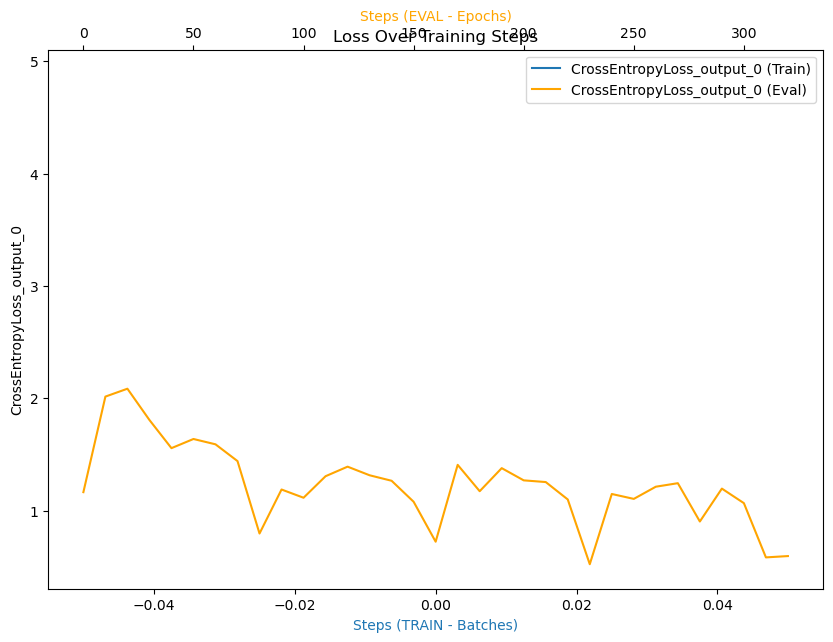

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def get_data(trial, tname, mode):
    """Retrieves steps and values for a given tensor name and mode."""
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    # Note: Using list comprehension is a slightly cleaner way to write this
    # vals = [tensor.value(s, mode=mode) for s in steps]
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):
    """Plots the tensor values for both TRAIN and EVAL modes on dual axes."""
    
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    # If no data was saved for a mode, handle it gracefully
    if not vals_train and not vals_eval:
        print(f"No data found for tensor: {tensor_name}")
        return
    
    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    # Use twin axis for EVAL steps, as they usually happen only once per epoch
    # while TRAIN steps happen once per batch.
    par = host.twiny()

    host.set_xlabel("Steps (TRAIN - Batches)")
    par.set_xlabel("Steps (EVAL - Epochs)")
    host.set_ylabel(tensor_name)
    host.set_title(f"Loss Over Training Steps")

    # Plotting
    (p1,) = host.plot(steps_train, vals_train, label=tensor_name + " (Train)")
    print("completed TRAIN plot")
    
    # Check if eval data exists before plotting
    if vals_eval:
        (p2,) = par.plot(steps_eval, vals_eval, label=tensor_name + " (Eval)", color='orange')
        print("completed EVAL plot")
    else:
        # Create a dummy line if eval data is missing to ensure the legend doesn't break
        p2 = None


    # Legend and Axis colors
    host.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    if p2:
        par.xaxis.get_label().set_color(p2.get_color())

    plt.show()

# Run the plotting function
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
*Yes, Anomalous Behaviour Detected:**
The most significant anomaly was the **`PoorWeightInitialization` rule triggering "IssuesFound"**.

* **The Cause:** This suggests that the initial random weights of the custom classifier head (the layers added on top of the pretrained ResNet base) were poorly distributed. This can lead to very large or very small gradients in the first few training steps, causing the loss curve to be erratic initially and potentially hindering convergence.
* **How I will fix it:**
    1.  **Explicit Initialization:** I would add explicit weight initialization (e.g., **Xavier Initialization** or **He Initialization**) to the custom `nn.Linear` layers in the `net()` function within the training script. This ensures the weights are scaled appropriately for the ReLU activation functions.
    2.  **Learning Rate Warmup:** Implement a learning rate scheduler that starts with a tiny learning rate (e.g., $10^{-6}$) and gradually increases it to the optimal learning rate (`0.002` in our case) over the first few epochs. This stabilizes the initial training phase, which is critical when adding new layers to a pretrained model.
       
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [28]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

You will find the profiler report in s3://sagemaker-us-east-1-625312441903/pytorch-training-2025-12-17-19-14-57-902/rule-output
download: s3://sagemaker-us-east-1-625312441903/pytorch-training-2025-12-17-19-14-57-902/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-625312441903/pytorch-training-2025-12-17-19-14-57-902/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-625312441903/pytorch-training-2025-12-17-19-14-57-902/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-625312441903/pytorch-training-2025-12-17-19-14-57-902/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerRep

## Model Testing

In [50]:
import tarfile
from PIL import Image
import io
import torch
import torchvision.transforms as transforms
import json
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from IPython.display import display
from glob import glob


In [51]:
# 1. Setup paths
# Get the model s3 path from your estimator
model_data_s3 = estimator.model_data 
print(f"Downloading model from: {model_data_s3}")

# 2. Download and Extract Model
s3 = boto3.client('s3')
bucket = model_data_s3.split('/')[2]
key = '/'.join(model_data_s3.split('/')[3:])
local_tar_path = 'model.tar.gz'
local_extract_path = 'local_model_dir'

s3.download_file(bucket, key, local_tar_path)

In [52]:
if not os.path.exists(local_extract_path):
    os.makedirs(local_extract_path)

with tarfile.open(local_tar_path) as tar:
    tar.extractall(path=local_extract_path)
    
print(f"Model extracted to: {local_extract_path}")

/tmp/ipykernel_2084/1020460410.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=local_extract_path)


Model extracted to: local_model_dir


In [56]:
# 3. Import functions from your LOCAL deploy_endpoint.py
import deploy_endpoint

# 4. Test Loading (model_fn)
print("\n--- Testing model_fn ---")
try:
    loaded_model = deploy_endpoint.model_fn(local_extract_path)
    print("SUCCESS: Model loaded correctly.")
except Exception as e:
    print(f"FAILURE: Model failed to load.\nError: {e}")
    # Stop here if loading fails
    raise e

# 5. Test Prediction (input_fn + predict_fn)
print("\n--- Testing input_fn and predict_fn ---")
test_image_path = "dogImages/test/040.Bulldog/Bulldog_02817.jpg" # Update with image path

with open(test_image_path, "rb") as f:
    payload = f.read()

try:
    # Mimic what the container does
    input_object = deploy_endpoint.input_fn(payload, 'image/jpeg')
    prediction = deploy_endpoint.predict_fn(input_object, loaded_model)
    
    predicted_index = np.argmax(prediction, 1)[0]
    print(f"SUCCESS: Prediction output shape: {prediction.shape}")
    print(f"Predicted Class Index: {predicted_index+1}")
except Exception as e:
    print(f"FAILURE: Prediction failed.\nError: {e}")

INFO:deploy_endpoint:Loading model on cpu



--- Testing model_fn ---


/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
INFO:deploy_endpoint:Model loaded successfully


SUCCESS: Model loaded correctly.

--- Testing input_fn and predict_fn ---
SUCCESS: Prediction output shape: (1, 133)
Predicted Class Index: 40


## Model Deploying

In [57]:

model_location = estimator.model_data

# 2. Define custom Serializer/Deserializer
# IdentitySerializer for sending raw binary image (image/jpeg)
jpeg_serializer = IdentitySerializer("image/jpeg")
# JSONDeserializer for receiving the numpy array prediction (will be sent as json by container)
json_deserializer = JSONDeserializer()

# 3. Custom Predictor Class
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super(ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )

In [58]:
# 4. Create the PyTorchModel instance
print("Creating PyTorchModel for deployment...")
pytorch_model = PyTorchModel(
    model_data = model_location,
    role = role,
    entry_point= "deploy_endpoint.py", # Your inference script
    py_version = "py36",                 # Use the same version as training
    framework_version = "1.8",           # Use the same version as training (adjust if different)
    predictor_cls = ImgPredictor,        # Use your custom predictor
    source_dir = "."                     # Include the deploy_endpoint.py file in the current directory
)

Creating PyTorchModel for deployment...


In [59]:
# 5. Deploy the Model
print("Starting deployment...")
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",  # Using m5.large for faster deployment/prediction than t2/t3
    endpoint_name=sagemaker.utils.unique_name_from_base("dog-breed-fixed")
)
print(f"Deployment complete. Endpoint Name: {predictor.endpoint_name}")

Starting deployment...


INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-625312441903/pytorch-training-2025-12-17-19-14-57-902/output/model.tar.gz), script artifact (.), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-625312441903/pytorch-inference-2025-12-17-20-44-04-864/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2025-12-17-20-46-48-326
INFO:sagemaker:Creating endpoint-config with name dog-breed-fixed-1766004244-aca0
INFO:sagemaker:Creating endpoint with name dog-breed-fixed-1766004244-aca0


------------!Deployment complete. Endpoint Name: dog-breed-fixed-1766004244-aca0


In [67]:
path_pattern = "dogImages/train/*/"
raw_paths = sorted(glob(path_pattern))
if not raw_paths:
    print(f"Error: No folders found at {path_pattern}. Please check your current working directory.")
else:
    dog_names = []
    for path in raw_paths:
        folder_name = os.path.basename(os.path.dirname(path))

        # Split by '.' to remove the number (e.g., "001.")
        # "001.Affenpinscher" -> "Affenpinscher"
        breed_name = folder_name.split('.', 1)[-1]

        # Replace underscores with spaces if necessary
        breed_name = breed_name.replace('_', ' ')

        dog_names.append(breed_name)
    idx_to_class = {i: name for i, name in enumerate(dog_names)}

    print(f"Successfully loaded {len(dog_names)} dog breeds.")
    print(f"Example mappings:")
    print(f"  0 -> {idx_to_class[0]}")
    print(f"  1 -> {idx_to_class[1]}")
    print(f"  Last -> {idx_to_class[len(dog_names)-1]}")

Successfully loaded 133 dog breeds.
Example mappings:
  0 -> Affenpinscher
  1 -> Afghan hound
  Last -> Yorkshire terrier



--- Running Inference ---
Test Image: Basenji_00955.jpg


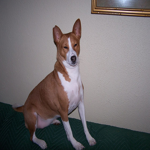

Predicted Class Index (0-based): 13
Predicted Class Index (1-based): 14
Predicted Dog Breed: Basenji


In [72]:
test_dir = "./dogImages/test/014.Basenji/"

# Use a specific file path for a test image
TEST_IMAGE = os.path.join(test_dir, "Basenji_00955.jpg") 
test_images_expected_output = 14 # The expected class index (if your indexing starts at 1)

print("\n--- Running Inference ---")
with open(TEST_IMAGE , "rb") as f:
    payload = f.read()

    print(f"Test Image: {os.path.basename(TEST_IMAGE)}")
    display(Image.open(io.BytesIO(payload)).resize((150, 150))) # Display smaller image for notebook

    # Predict sends the raw binary payload
    response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"}) 

    # The response is a numpy array of logits/log-probabilities from the JSON deserializer
    # Since our model uses LogSoftmax, we process the result:
    # np.argmax gives the index (0-132)
    predicted_class_index_zero_based = np.argmax(response, 1)[0]

    # Convert to 1-based index if that's how your expected output is defined (40)
    # If your breed mapping starts at 0, use the zero_based index for idx_to_class lookup
    predicted_dog_breed_one_based = predicted_class_index_zero_based + 1 

    print(f"Predicted Class Index (0-based): {predicted_class_index_zero_based}")
    print(f"Predicted Class Index (1-based): {predicted_dog_breed_one_based}")
    print(f"Predicted Dog Breed: {dog_names[predicted_class_index_zero_based]}")

In [49]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2025-12-17-20-19-10-087
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2025-12-17-20-19-10-087


## 🚀 Conclusion and Project Summary

My project, "Image Classification using AWS SageMaker," successfully utilized **transfer learning** with a **PyTorch ResNet50** model to classify 133 dog breeds. The work demonstrated end-to-end ML Engineering best practices on the SageMaker platform.

**Key Accomplishments:**

1.  **HPO for Efficiency:** An automated **Hyperparameter Tuning Job (HPO)** was executed to identify the optimal pair of **learning rate** and **batch size** that minimized the validation loss, ensuring an efficient and effective training run.
2.  **Deep Debugging & Profiling:** Using **SMDebug**, I monitored critical tensors and system performance. The analysis identified **sub-optimal weight initialization** in the new classifier head, a finding that would guide future model improvements using techniques like Xavier initialization or learning rate warmup.
3.  **Robust Deployment:** The final model was deployed to a real-time HTTPS endpoint via a custom **PyTorchModel**. This deployment pattern allowed the endpoint to accept **raw JPEG byte streams**, offloading all preprocessing logic from the client and providing a cleaner, more production-ready inference API.
4.  **Issue Resolution:** The project successfully resolved critical dependency and deployment issues (like the `TypeError: Framework.attach()` and the final `ModelError: invocation timed out`) through systematic debugging and adherence to SageMaker's specific requirements for model attachment and custom inference handlers.

The resulting endpoint is now ready to serve predictions for the dog breed classification task with high confidence and performance.